#### Based on [`"Using GAN for Generating Hand-written Digit Images" by Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/gan_mnist.ipynb)
## ✒️ &nbsp; Styling, Libraries, and Helpful Functions

In [1]:
%%html
<style>        
h2,h4 {text-shadow:4px 4px 4px #ccc;} 
span {text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color: #39d4be;} 
div.input_prompt {color: #37c9e1;} 
div.output_area pre, div.output_subarea {color: #39d4be;}
div.output_stderr pre {background-color: ghostwhite;}
</style>

In [2]:
import warnings; warnings.filterwarnings("ignore")
import h5py,urllib,zipfile
import pandas as pd,numpy as np,pylab as pl
import keras as ks,tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,Nadam
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
i0,i1,i2,i3,i4,i5,i6,i7,i8=\
int(0),int(1),int(2),int(3),int(4),int(5),int(6),int(7),int(8)
i32,i128,i255,i1024=int(32),int(128),int(255),int(1024)
np.set_printoptions(precision=8); il=10**2
from keras import __version__
print('keras version:',__version__)
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0-rc1


In [3]:
def preprocess(x):    
    x=(x-.5)*2
    return np.clip(x,-i1,i1)
def deprocess(x):
    x=(x/2+.5)*255
#    np.place(x,x>220,i255)
    x=np.clip(x,i0,i255)
    x=np.uint8(x)
    return x.reshape(i32,i32)
def latent_samples(n_samples,sample_size):
    return np.random.normal(loc=i0,scale=i1,
                            size=(n_samples,sample_size))
latent_sample1024=latent_samples(i1,i1024)
latent_sample128=latent_samples(i1,i128)
def display_images(generated_images):
    n_images=len(generated_images)
    rows=i4; cols=n_images//rows    
    pl.figure(figsize=(cols,rows))
    for i in range(n_images):
        img=deprocess(generated_images[i])
        pl.subplot(rows,cols,i+i1)
        pl.imshow(img,cmap=pl.cm.Greys)
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()

## ✒️ &nbsp; Loading & Preprocessing the Data

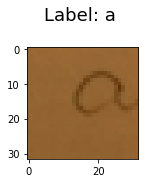

In [4]:
f=h5py.File('../input/LetterColorImages2.h5','r')
keys=list(f.keys())
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
images=np.array(f[keys[1]])/255
labels=np.array(f[keys[2]])
pl.figure(figsize=(2,3))
pl.title('Label: %s \n'%letters[labels[il]-i1],
         fontsize=18)
pl.imshow(images[il]); pl.show()

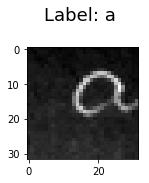

((5940, 1024), dtype('float64'))

In [5]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
gray_images=gray_images.reshape(-i1,i32*i32)
pl.figure(figsize=(2,3))
pl.title('Label: %s \n'%letters[labels[il]-i1],fontsize=18)
img=np.array(gray_images[il].reshape(32,32))
pl.imshow(img.astype(float),
          cmap=pl.cm.Greys); pl.show()
del images
gray_images.shape,gray_images.dtype

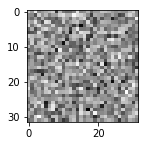

In [6]:
pl.figure(figsize=(2,3))
img0=np.squeeze(latent_sample1024).reshape(i32,i32)
pl.imshow(img0,cmap=pl.cm.Greys); pl.show()

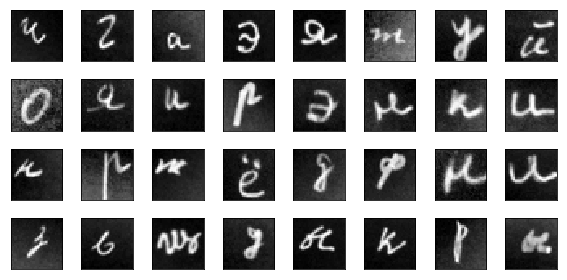

((5346, 1024), (594, 1024))

In [7]:
X_train_real,X_test_real=\
train_test_split(gray_images,test_size=.1)
X_train_real=preprocess(X_train_real)
X_test_real=preprocess(X_test_real)
display_images(X_train_real[:i32])
X_train_real.shape,X_test_real.shape

## ✒️ &nbsp; Keras GAN
#### A Simple Example

In [8]:
discriminator=Sequential([Dense(i128,input_shape=(i1024,)),
                          LeakyReLU(alpha=.01),
                          Dense(i1),Activation('sigmoid')], 
                         name='discriminator')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 131,329
Trainable params: 131,329
Non-trainable params: 0
_________________________________________________________________


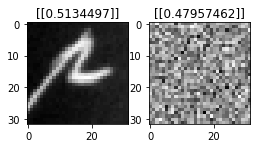

In [9]:
fig=pl.figure(figsize=(4,3))
ax=fig.add_subplot(121)
img=X_train_real[il].reshape(i1,i1024)
ax.set_title(discriminator.predict(img))
ax.imshow(img.reshape(i32,i32),cmap=pl.cm.Greys)
ax=fig.add_subplot(122)
ax.set_title(discriminator.predict(img0.reshape(i1,i1024)))
ax.imshow(img0,cmap=pl.cm.Greys); pl.show()

In [10]:
generator=Sequential([Dense(i1024,input_shape=(i128,)),
                      LeakyReLU(alpha=.01),
                      Dense(i1024),Activation('tanh')], 
                     name='generator')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              132096    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
Total params: 1,181,696
Trainable params: 1,181,696
Non-trainable params: 0
_________________________________________________________________


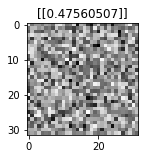

In [11]:
pl.figure(figsize=(2,3))
generated_latent_sample=generator.predict(latent_sample128)
pl.title(discriminator.predict(generated_latent_sample))
pl.imshow(generated_latent_sample.reshape(i32,i32),
           cmap=pl.cm.Greys); pl.show()

In [12]:
gan=Sequential([generator,discriminator])
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 1024)              1181696   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 131329    
Total params: 1,313,025
Trainable params: 1,313,025
Non-trainable params: 0
_________________________________________________________________


#### Building the GAN Model

In [13]:
def trainable(model,trainable):
    for layer in model.layers:
        layer.trainable=trainable
def simple_GAN(sample_size, 
               g_hidden_size, 
               d_hidden_size, 
               leaky_alpha, 
               g_learning_rate,
               d_learning_rate):    
    ks.backend.clear_session()    
    generator=Sequential([Dense(g_hidden_size,input_shape=(sample_size,)),
                          LeakyReLU(alpha=leaky_alpha),
                          Dense(i1024),Activation('tanh')], 
                         name='generator')    
    discriminator=Sequential([Dense(d_hidden_size,input_shape=(i1024,)),
                              LeakyReLU(alpha=leaky_alpha),
                              Dense(i1),Activation('sigmoid')], 
                             name='discriminator')        
    gan=Sequential([generator,discriminator])    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), 
                          loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), 
                loss='binary_crossentropy')   
    return gan,generator,discriminator

In [14]:
sample_size    =i128     
g_hidden_size  =i1024  # generator
d_hidden_size  =i128   # discriminator
leaky_alpha    =.02
g_learning_rate=.0001 # generator
d_learning_rate=.0007   # discriminator
epochs         =int(1000)
batch_size     =int(128)      
valid_size     =int(16)     
smooth         =.075
def real_fake_labels(size):
    return np.ones([size,i1]),np.zeros([size,i1])
y_real5,y_fake5=real_fake_labels(5)
print('Real\n',list(y_real5),'\nFake\n',list(y_fake5))
y_train_real,y_train_fake=real_fake_labels(batch_size)
y_valid_real,y_valid_fake=real_fake_labels(valid_size)
gan,generator,discriminator=\
simple_GAN(sample_size,g_hidden_size,d_hidden_size,
           leaky_alpha,g_learning_rate,d_learning_rate)

Real
 [array([1.]), array([1.]), array([1.]), array([1.]), array([1.])] 
Fake
 [array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]


Epoch: 10/1000 | Discriminator Loss: 0.0697 | Generator Loss: 5.0876 | DL > GL: False
Epoch: 20/1000 | Discriminator Loss: 0.0958 | Generator Loss: 5.0426 | DL > GL: False
Epoch: 30/1000 | Discriminator Loss: 0.3516 | Generator Loss: 2.2702 | DL > GL: False
Epoch: 40/1000 | Discriminator Loss: 0.3410 | Generator Loss: 2.0653 | DL > GL: False
Epoch: 50/1000 | Discriminator Loss: 0.3598 | Generator Loss: 1.9793 | DL > GL: False
Epoch: 60/1000 | Discriminator Loss: 0.3877 | Generator Loss: 2.5523 | DL > GL: False
Epoch: 70/1000 | Discriminator Loss: 0.5838 | Generator Loss: 2.2294 | DL > GL: False
Epoch: 80/1000 | Discriminator Loss: 0.3418 | Generator Loss: 1.8276 | DL > GL: False
Epoch: 90/1000 | Discriminator Loss: 0.5132 | Generator Loss: 1.9432 | DL > GL: False
Epoch: 100/1000 | Discriminator Loss: 0.5895 | Generator Loss: 1.4118 | DL > GL: False
Epoch: 110/1000 | Discriminator Loss: 0.9529 | Generator Loss: 2.0967 | DL > GL: False
Epoch: 120/1000 | Discriminator Loss: 0.4470 | Gener

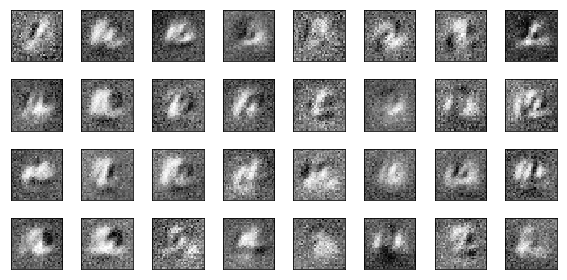

Epoch: 280/1000 | Discriminator Loss: 1.1485 | Generator Loss: 1.0648 | DL > GL: True
Epoch: 290/1000 | Discriminator Loss: 1.1937 | Generator Loss: 1.4301 | DL > GL: False
Epoch: 300/1000 | Discriminator Loss: 1.4208 | Generator Loss: 0.9727 | DL > GL: True
Epoch: 310/1000 | Discriminator Loss: 0.7410 | Generator Loss: 1.3405 | DL > GL: False
Epoch: 320/1000 | Discriminator Loss: 1.4682 | Generator Loss: 1.0366 | DL > GL: True
Epoch: 330/1000 | Discriminator Loss: 0.9059 | Generator Loss: 1.5241 | DL > GL: False
Epoch: 340/1000 | Discriminator Loss: 0.8392 | Generator Loss: 1.1981 | DL > GL: False
Epoch: 350/1000 | Discriminator Loss: 1.0320 | Generator Loss: 1.3439 | DL > GL: False
Epoch: 360/1000 | Discriminator Loss: 1.1392 | Generator Loss: 1.0481 | DL > GL: True
Epoch: 370/1000 | Discriminator Loss: 1.4287 | Generator Loss: 0.7263 | DL > GL: True


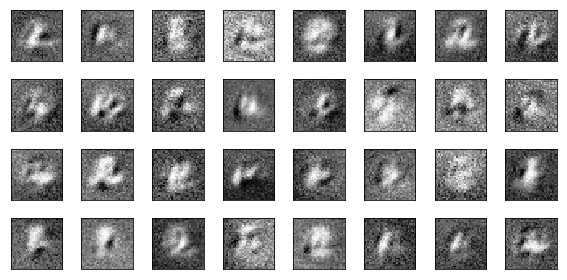

Epoch: 380/1000 | Discriminator Loss: 1.0346 | Generator Loss: 1.3983 | DL > GL: False
Epoch: 390/1000 | Discriminator Loss: 1.1206 | Generator Loss: 1.2147 | DL > GL: False
Epoch: 400/1000 | Discriminator Loss: 1.1987 | Generator Loss: 1.1765 | DL > GL: True
Epoch: 410/1000 | Discriminator Loss: 1.4340 | Generator Loss: 1.0235 | DL > GL: True
Epoch: 420/1000 | Discriminator Loss: 0.7421 | Generator Loss: 1.5539 | DL > GL: False
Epoch: 430/1000 | Discriminator Loss: 0.7185 | Generator Loss: 1.4228 | DL > GL: False
Epoch: 440/1000 | Discriminator Loss: 1.2176 | Generator Loss: 1.2072 | DL > GL: True
Epoch: 450/1000 | Discriminator Loss: 0.6063 | Generator Loss: 1.6473 | DL > GL: False
Epoch: 460/1000 | Discriminator Loss: 1.0595 | Generator Loss: 1.3036 | DL > GL: False
Epoch: 470/1000 | Discriminator Loss: 0.9422 | Generator Loss: 0.7707 | DL > GL: True


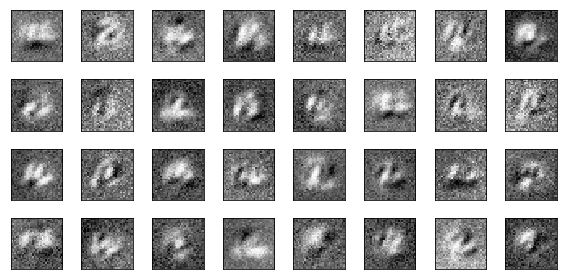

Epoch: 480/1000 | Discriminator Loss: 0.5168 | Generator Loss: 1.8683 | DL > GL: False
Epoch: 490/1000 | Discriminator Loss: 1.4763 | Generator Loss: 1.1574 | DL > GL: True
Epoch: 500/1000 | Discriminator Loss: 1.0043 | Generator Loss: 1.7502 | DL > GL: False
Epoch: 510/1000 | Discriminator Loss: 0.9254 | Generator Loss: 1.4420 | DL > GL: False
Epoch: 520/1000 | Discriminator Loss: 1.1085 | Generator Loss: 1.1525 | DL > GL: False
Epoch: 530/1000 | Discriminator Loss: 0.9944 | Generator Loss: 1.6535 | DL > GL: False
Epoch: 540/1000 | Discriminator Loss: 0.8969 | Generator Loss: 1.1029 | DL > GL: False
Epoch: 550/1000 | Discriminator Loss: 0.8883 | Generator Loss: 1.4777 | DL > GL: False
Epoch: 560/1000 | Discriminator Loss: 0.8306 | Generator Loss: 1.0978 | DL > GL: False
Epoch: 570/1000 | Discriminator Loss: 0.7193 | Generator Loss: 1.5087 | DL > GL: False
Epoch: 580/1000 | Discriminator Loss: 1.0002 | Generator Loss: 1.1069 | DL > GL: False
Epoch: 590/1000 | Discriminator Loss: 0.8962

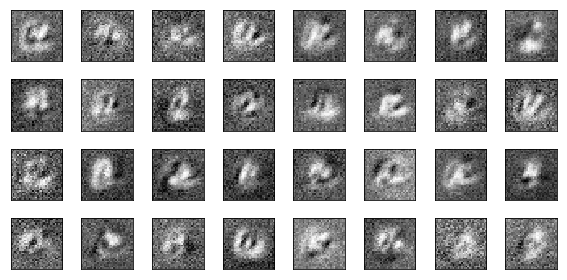

Epoch: 810/1000 | Discriminator Loss: 0.8055 | Generator Loss: 1.2844 | DL > GL: False
Epoch: 820/1000 | Discriminator Loss: 1.6279 | Generator Loss: 1.6548 | DL > GL: False
Epoch: 830/1000 | Discriminator Loss: 1.1113 | Generator Loss: 1.5671 | DL > GL: False
Epoch: 840/1000 | Discriminator Loss: 0.6680 | Generator Loss: 1.3478 | DL > GL: False
Epoch: 850/1000 | Discriminator Loss: 0.8955 | Generator Loss: 1.3219 | DL > GL: False
Epoch: 860/1000 | Discriminator Loss: 1.2309 | Generator Loss: 1.2107 | DL > GL: True
Epoch: 870/1000 | Discriminator Loss: 0.8549 | Generator Loss: 1.3831 | DL > GL: False
Epoch: 880/1000 | Discriminator Loss: 0.6172 | Generator Loss: 1.4849 | DL > GL: False
Epoch: 890/1000 | Discriminator Loss: 1.1913 | Generator Loss: 1.0634 | DL > GL: True
Epoch: 900/1000 | Discriminator Loss: 0.9892 | Generator Loss: 1.1964 | DL > GL: False
Epoch: 910/1000 | Discriminator Loss: 0.8707 | Generator Loss: 1.7997 | DL > GL: False
Epoch: 920/1000 | Discriminator Loss: 1.3411 

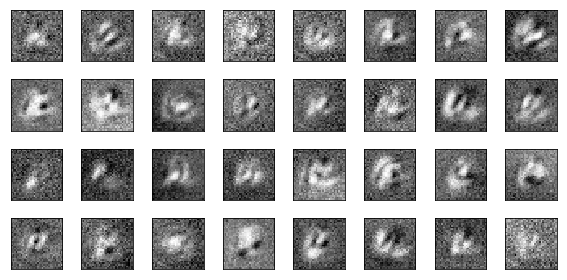

Epoch: 930/1000 | Discriminator Loss: 1.6817 | Generator Loss: 0.6261 | DL > GL: True


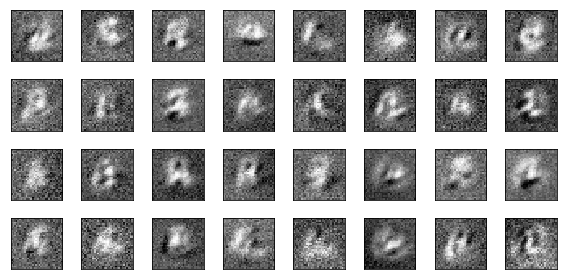

Epoch: 940/1000 | Discriminator Loss: 0.9890 | Generator Loss: 1.5451 | DL > GL: False
Epoch: 950/1000 | Discriminator Loss: 1.2862 | Generator Loss: 0.8848 | DL > GL: True


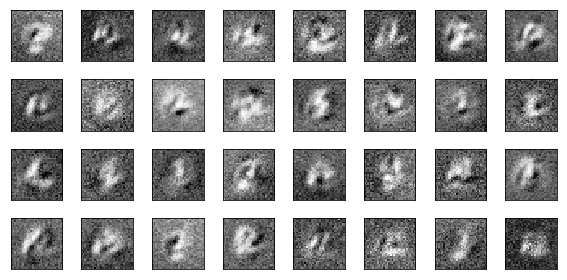

Epoch: 960/1000 | Discriminator Loss: 1.2924 | Generator Loss: 0.7447 | DL > GL: True


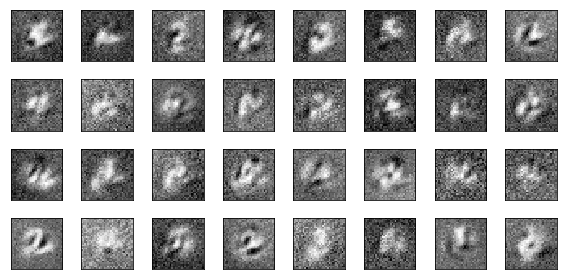

Epoch: 970/1000 | Discriminator Loss: 1.2643 | Generator Loss: 1.0695 | DL > GL: True
Epoch: 980/1000 | Discriminator Loss: 0.8286 | Generator Loss: 1.0946 | DL > GL: False
Epoch: 990/1000 | Discriminator Loss: 1.1028 | Generator Loss: 1.6053 | DL > GL: False
Epoch: 1000/1000 | Discriminator Loss: 0.7380 | Generator Loss: 1.4177 | DL > GL: False


In [15]:
losses=[]
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real images
        X_batch_real=X_train_real[i*batch_size:(i+1)*batch_size]        
        # latent samples and generated letter images
        batch_latent_samples=latent_samples(batch_size,sample_size)
        X_batch_fake=generator.predict_on_batch(batch_latent_samples)        
        # train the discriminator to detect real and fake images
        trainable(discriminator,True)
        discriminator.train_on_batch(X_batch_real,y_train_real*(1.-smooth))
        discriminator.train_on_batch(X_batch_fake,y_train_fake)
        # train the generator via GAN
        trainable(discriminator,False)
        gan.train_on_batch(batch_latent_samples,y_train_real)    
    # evaluate
    X_valid_real=X_test_real[np.random.choice(len(X_test_real), 
                                              valid_size,replace=False)]    
    valid_latent_samples=latent_samples(valid_size,sample_size)
    X_valid_fake=generator.predict_on_batch(valid_latent_samples)
    d_loss=discriminator.test_on_batch(X_valid_real,y_valid_real)
    d_loss+=discriminator.test_on_batch(X_valid_fake,y_valid_fake)
    g_loss=gan.test_on_batch(valid_latent_samples,y_valid_real)     
    losses.append((d_loss,g_loss))
    st="Epoch: %d/%d | Discriminator Loss: %.4f | "+\
       "Generator Loss: %.4f | DL > GL: %s"
    if (e+i1)%int(10)==i0:
        print(st%((e+i1,epochs,d_loss,g_loss,d_loss>g_loss)))
        if ((g_loss<.9) and (d_loss>g_loss)):
            latent_examples=latent_samples(i32,sample_size)
            generated_letters=generator.predict(latent_examples)
            display_images(generated_letters)

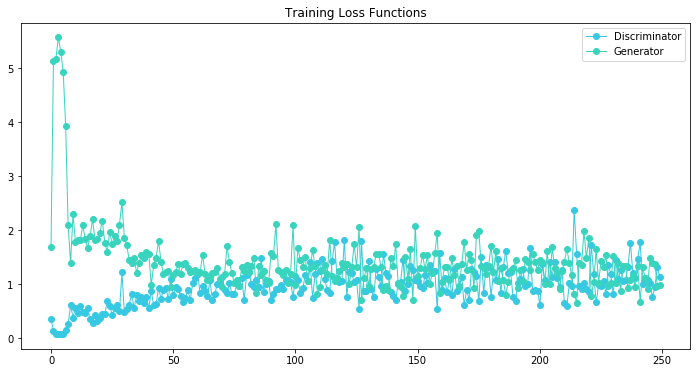

In [16]:
def display_loss(losses,n):
    indices=[i*n for i in range(len(losses)//n)]
    n_losses=np.array(losses)[indices,:]    
    pl.figure(figsize=(12,6))
    pl.plot(n_losses.T[i0],'-o',c='#37c9e1',lw=i1,
            label='Discriminator')
    pl.plot(n_losses.T[1],'-o',c='#39d4be',lw=i1,
            label='Generator')
    pl.title("Training Loss Functions")
    pl.legend(); pl.show()
display_loss(losses,i4)